In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp
import numba as nb

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 6

mtype = "small_world"
n = 7020
# G = nx.connected_watts_strogatz_graph(n, k=4, p=0.1)
# G.remove_edges_from(nx.selfloop_edges(G))
# G = nx.DiGraph(G)

beta = 0.7
gamma = 0.01
G = nx.scale_free_graph(n, alpha=1-beta-gamma, beta=beta, gamma=gamma)#alpha=0.41, beta=0.54)

n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=7020, G.number_of_edges()=23853
[572, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

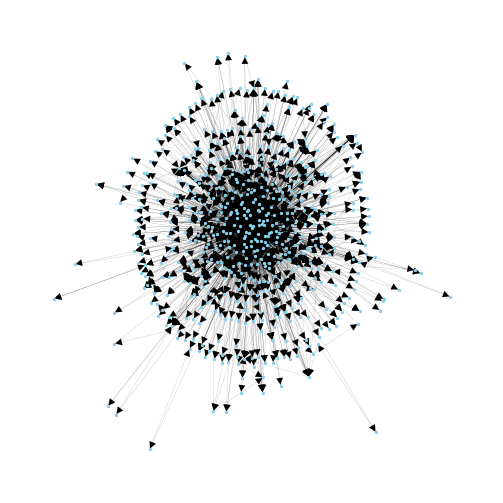

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_strongly_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([0.00388619, 0.24021957, 0.22737664, 0.02706734, 0.00145025]),
 array([ 0.,  2.,  4.,  6.,  8., 10.]))

In [6]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([1.22064092e-02, 9.26482673e-06, 0.00000000e+00, 4.63241337e-06,
        4.63241337e-06]),
 array([  1. ,  82.8, 164.6, 246.4, 328.2, 410. ]))

In [9]:
info = {} 

In [10]:
fraction_of_nodes = 0.5
pi_rows = np.random.permutation(n)[:int(n * fraction_of_nodes)]
pi_cols = np.random.permutation(n)[:int(n * fraction_of_nodes)+10]

pi_row_Dist = ldr.sparse_sampled_matrix(pi_rows, Dist, rows=True)
pi_col_Dist_T = ldr.sparse_sampled_matrix(pi_cols, Dist, rows=False)

rDist = np.zeros((n, n))
rDist[pi_rows] = Dist[pi_rows]
assert np.allclose(pi_row_Dist.toarray(), rDist)

cDist = np.zeros((n, n))
cDist[:, pi_cols] = Dist[:, pi_cols]
assert np.allclose(pi_col_Dist_T.T.toarray(), cDist)
print("PASSED")

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

pi_rows_c = np.delete(np.arange(n), pi_rows)
pi_cols_c = np.delete(np.arange(n), pi_cols)

PASSED


In [11]:
for _ in range(10):
    Z0 = np.random.randn(2*n, rank//2)
    X, Y = Z0[:n], Z0[n:]

    d_X = np.einsum('ik,ik->i', X, X)
    d_Y = np.einsum('ik,ik->i', Y, Y)

    res3 = ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)
    res1 = ldr.product_BZ(pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, X, Y, rank, n, d_X, d_Y)
    assert np.allclose(res1, res3)
    
print("PASSED")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


PASSED


In [12]:
%timeit ldr.product_BZ(pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, X, Y, rank, n, d_X, d_Y)

8.15 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)

4.46 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
L, L_inv = ldr.laplacian_from_row_col_pi(pi_rows, pi_cols, n, debug=False)


L2 = np.zeros((2*n, 2*n))
for i in pi_rows:
    for j in range(n):
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1
for j in pi_cols:
    for i in range(n):
        if L2[i, n+j] == -1: continue
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1

assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))

print("PASSED")

PASSED


In [15]:
D_minsqrt = np.power(np.diag(L), -0.5)
N = (D_minsqrt[:, np.newaxis] * L) * D_minsqrt[np.newaxis, :]

assert np.allclose(N, np.diag(D_minsqrt) @ L @ np.diag(D_minsqrt)) and np.allclose(np.ones(L.shape[0]), np.diag(N))
print("PASSED")

PASSED


In [16]:
for i in range(2*n):
    b0 = np.eye(2*n)[i]#np.random.randn(2*n)
    res3 = L @ b0
    res1 = ldr.product_Lb(pi_rows, pi_cols, pi_rows_c, pi_cols_c, b0, n)
    assert np.allclose(res1, res3)
print("PASSED")

PASSED


In [17]:
%timeit L @ b0

113 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit ldr.product_Lb(pi_rows, pi_cols, pi_rows_c, pi_cols_c, b0, n)

5.34 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
b0 = np.random.randn(2*n)
x = np.zeros(2*n)
r = b0
max_iter = 100
rho0 = rho1 = np.square(r).sum()
losses = []
b_norm = np.linalg.norm(b0, ord=2)

for k in range(max_iter):
    if k == 0: p = r
    else: p = r + (rho1/rho0) * p
    w = ldr.product_Lb(pi_rows, pi_cols, pi_rows_c, pi_cols_c, b0, n)
    alpha = rho1 / np.dot(p, w)
    x += alpha * p 
    r -= alpha * w
    rho1 = np.square(r).sum()
    losses += [np.sqrt(rho1) / b_norm]
    print(k, rho1, losses[-1])

0 116.82377830187605
1 13.017587180383831
2 4.046116202282278
3 3.4405576102874105
4 3.5922960529702723
5 3.2045433444271403
6 3.565835188090652
7 3.2040830607808464
8 3.5657578582737335
9 3.2040651519498584
10 3.5657511798733648
11 3.204062730616407
12 3.565750127237077
13 3.2040623255576017
14 3.5657499458798507
15 3.204062255047855
16 3.5657499141534
17 3.204062242691937
18 3.565749908589211
19 3.20406224052435
20 3.5657499076129584
21 3.2040622401440246
22 3.5657499074416448
23 3.204062240077275
24 3.565749907411607
25 3.204062240065607
26 3.5657499074063628
27 3.204062240063538
28 3.5657499074054235
29 3.204062240063177
30 3.5657499074052863
31 3.204062240063129
32 3.5657499074052623
33 3.2040622400631094
34 3.5657499074052863
35 3.204062240063106
36 3.565749907405343
37 3.2040622400631054
38 3.5657499074053365
39 3.2040622400631222
40 3.5657499074053116
41 3.204062240063096
42 3.565749907405253
43 3.2040622400630903
44 3.5657499074053174
45 3.204062240063092
46 3.5657499074052867